In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error, r2_score,median_absolute_error, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [3]:
df = pd.read_csv("sourceData.csv")
df.head()
# df.describe()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,SE,FT,Solutions Engineer,214000,USD,214000,US,100,US,M
1,2025,SE,FT,Solutions Engineer,136000,USD,136000,US,100,US,M
2,2025,MI,FT,Data Engineer,158800,USD,158800,AU,0,AU,M
3,2025,MI,FT,Data Engineer,139200,USD,139200,AU,0,AU,M
4,2025,EN,FT,Data Engineer,90000,USD,90000,US,0,US,M


In [5]:
# training variables
target = df.columns[4]
print("target:",target)
# number epochs
epchs = 10 #int(input("enter number of epochs: "))

#
y = df[target]
X_df = df.drop(columns=[target])
# select columns NOT to be used for Feature Extraction
# features = X_df.columns[]
X = X_df #.drop(columns=features)
print("Features from:")
X.head()


target: salary
Features from:


,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,SE,FT,Solutions Engineer,USD,214000,US,100,US,M
1,2025,SE,FT,Solutions Engineer,USD,136000,US,100,US,M
2,2025,MI,FT,Data Engineer,USD,158800,AU,0,AU,M
3,2025,MI,FT,Data Engineer,USD,139200,AU,0,AU,M
4,2025,EN,FT,Data Engineer,USD,90000,US,0,US,M


In [6]:
# determine task type
is_classification = False if y.dtypes != "object" else True
print("class:",is_classification,"\n","type:",y.dtypes)

# handle taret encoding if classification
if is_classification:
    y = LabelEncoder().fit_transform(y)
    y = torch.tensor(y, dtype=torch.long)
    criterion = nn.CrossEntropyLoss()
    metric_name = "Accuracy"
else:
    y = torch.tensor(y.values, dtype=torch.float32)
    criterion = nn.MSELoss()
    metric_name = "MSE"

class: False 
 type: int64


In [7]:
# encode and scale features
X = pd.get_dummies(X, drop_first = True)
X = StandardScaler().fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# dataloader
train_set = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [36]:
# define custom model
class CustomModelA(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, len(torch.unique(y_train)) if is_classification else 1)
        )

    def forward(self, x):
        return self.net(x)

def model_training(models, X_train, X_test, y_train, y_test,clas):
    preds = []
    R2s= []
    MAEs= []
    MSLEs= []
    MAPEs = []
    MAbEs = []
    ClsReps = []
    CnfMtxs = []
    for model_name, model in models.items():
        X_test_t = X_test.to(device)
        # train
        model.fit(X_train, y_train)
        # predict
        pred = model.predict(X_test_t)
        preds.append(pred)
        # evaluate
        if not clas:
            r2 = r2_score(y_test, pred)
            R2s.append(r2)

            mae = mean_absolute_error(y_test, pred)
            MAEs.append(mae)

            if np.any(pred < 0):
                msle = "MSLE not calculated due to negative predictions"
            else:
                msle = mean_squared_log_error(y_test, pred)
            MSLEs.append(msle)

            mape = mean_absolute_percentage_error(y_test, pred)
            MAPEs.append(mape)

            mabe = median_absolute_error(y_test, pred)
            MAbEs.append(mabe)
        else:
            cls_rep = classification_report(y_test, pred)

            ClsReps.append(cls_rep)

            con_mat = confusion_matrix(y_test, pred)
            CnfMtxs.append(con_mat)

    return preds, R2s, MAEs, MSLEs, MAPEs, MAbEs, ClsReps, CnfMtxs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

In [37]:
# define scklearn models
svc = make_pipeline(StandardScaler(), svm.SVC(gamma="auto",kernel="rbf"))
RanForReg = RandomForestRegressor(n_estimators=10, max_features=2, max_leaf_nodes=5,random_state=42)
reg_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regression": RanForReg,
    "Decision Tree Regressor": DecisionTreeRegressor(max_depth=12),
}
clas_models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Classifier": svc,
    "Naive Bayes": GaussianNB(),
}
example_models = clas_models if is_classification else reg_models

# compare custom models
custom_models = {
    "Model A": CustomModelA(),
}

# experiment setup info
setup_info = {
    "Target Variable": target,
    "Task Type": "Classification" if is_classification else "Regression",
    "Feature Processing": "StandardScaler + One-Hot Encoding",
    "Validation Split": "80-20",
    "Batch Size": 32,
    "Epochs": epchs,
    "Optimizer": "Adam",
    "Loss Function": criterion.__class__.__name__,
}
print("The Experiment Settings")
pd.DataFrame([setup_info])

The Experiment Settings


,Target Variable,Task Type,Feature Processing,Validation Split,Batch Size,Epochs,Optimizer,Loss Function
0,salary,Regression,StandardScaler + One-Hot Encoding,80-20,32,10,Adam,MSELoss


In [38]:
# sklearn training and evaluatiom
preds, R2s, MAEs, MSLEs, MAbPEs, MAbEs, ClsReps, CnfMtxs = model_training(example_models, X_train, X_test, y_train, y_test, is_classification)

i = 0
for model_name, models in example_models.items():
    if not is_classification:
        results.append({
            "Model": model_name,
            "R2 Score": R2s[i],
            "Mean absolute error": MAEs[i],
            "Mean squared Log error": MSLEs[i],
            "Mean absolute percentage error": MAbPEs[i],
            "Median absolute error": MAbEs[i],
            "Predictions": preds[i],
        })
    else:
        results.append({
            "Model": model_name,
            "ClsReps": ClsReps[i],
            "CnfMtxs": CnfMtxs[i],
        })
    i +=1

In [40]:
# custom model training and evaluation
for model_name, model in custom_models.items():
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # training loop
    model.train()
    for epoch in range(setup_info["Epochs"]):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.flatten() #.cpu().numpy()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # evaluation
    model.eval()
    with torch.no_grad():
        X_test_t = X_test.to(device)
        y_pred = model(X_test_t)
        if is_classification:
            y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
            ClsReps = classification_report(y_test, y_pred)
            CnfMtxs = confusion_matrix(y_test, y_pred)
            results.append({
                "Model": model_name,
                "ClsReps": ClsReps,
                "CnfMtxs": CnfMtxs,
            })
        else:
            y_pred = y_pred.flatten().cpu().numpy()

            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            if np.any(y_pred < 0):
                msle = "MSLE not calculated due to negative predictions"
            else:
                msle = mean_squared_log_error(y_test, y_pred)
            MSLEs.append(msle)
            mape = mean_absolute_percentage_error(y_test, y_pred)
            mabe = median_absolute_error(y_test, y_pred)

            results.append({
                "Model": model_name,
                "R2 Score": r2,
                "Mean absolute error": mae,
                "Mean squared Log error": msle,
                "Mean absolute percentage error": mape,
                "Median absolute error": mabe,
                "Predictions": y_pred,
            })

In [41]:
# Display comparison
print("This is the ML Model Comparison")
display_results_df = pd.DataFrame(results).drop(columns="Predictions")
display_results_df

This is the ML Model Comparison


,Model,R2 Score,Mean absolute error,Mean squared Log error,Mean absolute percentage error,Median absolute error
0,Linear Regression,-48432287.30836,37685768.00000,MSLE not calculated due to negative predictions,307.17560,1677.00000
1,Random Forest Regression,0.00468,62657.34798,0.27449,0.52093,48306.71919
2,Decision Tree Regressor,0.47094,4161.58022,0.00940,0.03383,699.83042
3,Model A,0.36823,7077.84668,0.01123,0.03135,1777.19141


This is the ML Model Comparison


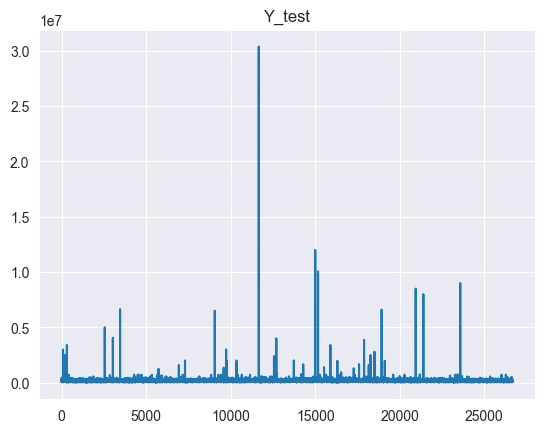

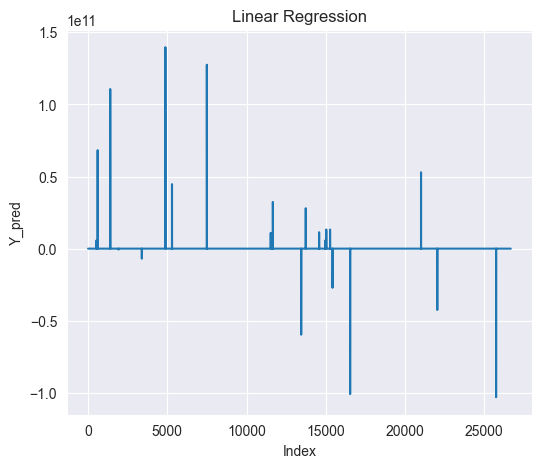

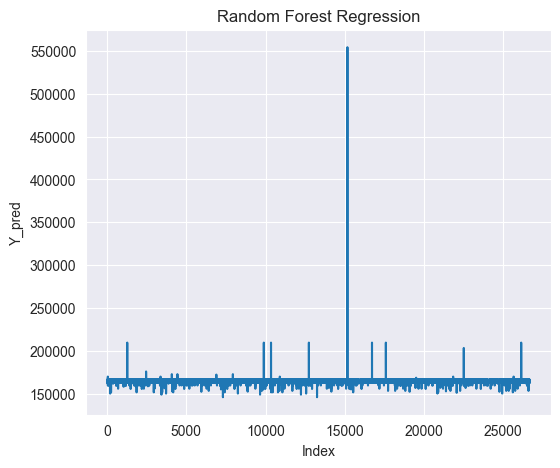

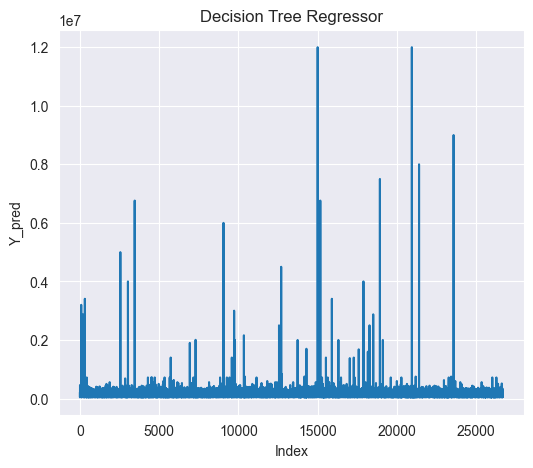

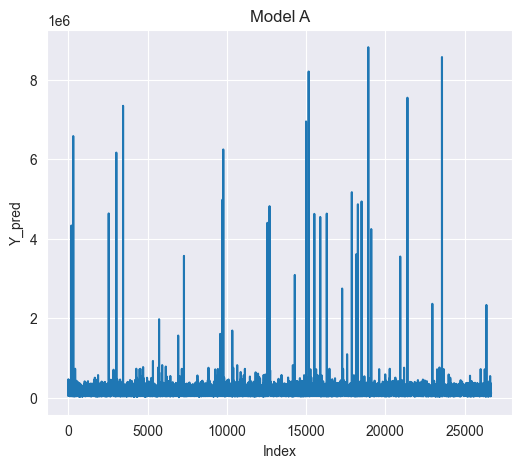

,Model,R2 Score,Mean absolute error,Mean squared Log error,Mean absolute percentage error,Median absolute error
0,Linear Regression,-48432287.30836,37685768.00000,MSLE not calculated due to negative predictions,307.17560,1677.00000
1,Random Forest Regression,0.00468,62657.34798,0.27449,0.52093,48306.71919
2,Decision Tree Regressor,0.47330,4138.06171,0.00939,0.03381,699.83042
3,Model A,0.00681,59617.42188,0.24683,0.46834,44111.62500
4,Model A,0.39559,9594.55371,0.04858,0.05999,2292.70312


In [57]:
# Display comparison
print("This is the ML Model Comparison")

if is_classification:
    for result in results:
        print("     Model: ", result["Model"])
        print("         Classification Report:")
        ClsReps = result["ClsReps"]
        print(ClsReps)
        print("         Confusion Matrix:")
        CnfMtxs = result["CnfMtxs"]
        labels = ['Class 0', 'Class 1']
        conf_matrix_df = pd.DataFrame(CnfMtxs, index=labels, columns=labels)
        conf_matrix_df.index.name = 'Actual'
        conf_matrix_df.columns.name = 'Predicted'

        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.show()  #fig = ---> st.pyplot(fig)
        print("\n\n")

else:
    sns.lineplot(y_test)
    plt.title('Y_test')
    for result in results:
        fig, ax = plt.subplots(figsize=(6, 5))
        sns.lineplot(result["Predictions"], ax=ax)
        ax.set_title(f'{result["Model"]}')
        ax.set_xlabel('Index')
        ax.set_ylabel('Y_pred')
        plt.show()  #fig = ---> st.pyplot(fig)
results_df

In [58]:
y_test
preds

AttributeError: 'Tensor' object has no attribute 'info'